In [3]:
import pandas as pd
import numpy as np
import patsy
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

sns.set(style="white")
%matplotlib inline
np.random.seed(1)

df = pd.read_csv("data/Default.csv", index_col=0)

df['default_yes'] = (df['default'] == 'Yes').astype('int')
df.head()

,default,student,balance,income,default_yes
1,No,No,729.526495,44361.625074,0
2,No,Yes,817.180407,12106.134700,0
3,No,No,1073.549164,31767.138947,0
4,No,No,529.250605,35704.493935,0
5,No,No,785.655883,38463.495879,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 5 columns):
default        10000 non-null object
student        10000 non-null object
balance        10000 non-null float64
income         10000 non-null float64
default_yes    10000 non-null int64
dtypes: float64(2), int64(1), object(2)
memory usage: 468.8+ KB


question 5 (a)

In [5]:
lr = LogisticRegression(C=10**6, tol=1e-6)
X = df[['income', 'balance']]
y = df['default_yes']
mod = lr.fit(X, y)
mod.coef_

array([[  2.07267113e-05,   5.64079143e-03]])

In [6]:
f = 'default_yes ~ income + balance'
res = smf.logit(formula=f, data=df).fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.078948
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            default_yes   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Tue, 06 Mar 2018   Pseudo R-squ.:                  0.4594
Time:                        08:40:00   Log-Likelihood:                -789.48
converged:                       True   LL-Null:                       -1460.3
                                        LLR p-value:                4.541e-292
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.5405      0.435    -26.544      0.000     -12.393     -10.688
income      2.081e-05   4.99e-06      4.174      0.000     1.1e-05    3.06e-05
balance        0.0056      0.000     24.835      0.000       0.005       0.006
==============================================================================

Possibly complete quasi-separation: A fraction 0.14 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

question 5 (b)(i)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

question 5 (b)(ii)

In [8]:
mod = lr.fit(X_train, y_train)
mod.coef_

array([[  1.62553551e-05,   5.83500517e-03]])

question 5 (b)(iii)

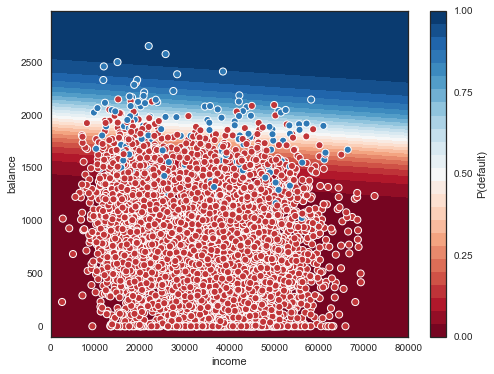

In [9]:
xx, yy = np.mgrid[0:80000:100, -100:3000:10]
grid = np.c_[xx.ravel(), yy.ravel()]                    # https://www.quora.com/Can-anybody-elaborate-the-use-of-c_-in-numpy
probs = mod.predict_proba(grid)[:, 1].reshape(xx.shape)
f, ax = plt.subplots(figsize=(8,6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",    # 25 levels
                     vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("P(default)")
ax_c.set_ticks([0,0.25,0.5,.75,1])

ax.scatter(X_test['income'], X_test['balance'], c=y_test, s=50, 
          cmap="RdBu", vmin=-0.2, vmax=1.2,
          edgecolor="white", linewidth=1)

ax.set(xlabel="income", ylabel="balance");

question 5 (b)(iv)
Answer:  General test error is 2.5% as given below. By the confusion matrix plotted below, our true positive rate is 0.3648, our false positive rate is 0.0050, our positive predictive value is 0.7073, our negative predictive value is 0.9795, and our accuracy is 0.9750.

In [10]:
y_pred = mod.predict(X_test)
1-(y_pred == y_test).mean()

0.025000000000000022

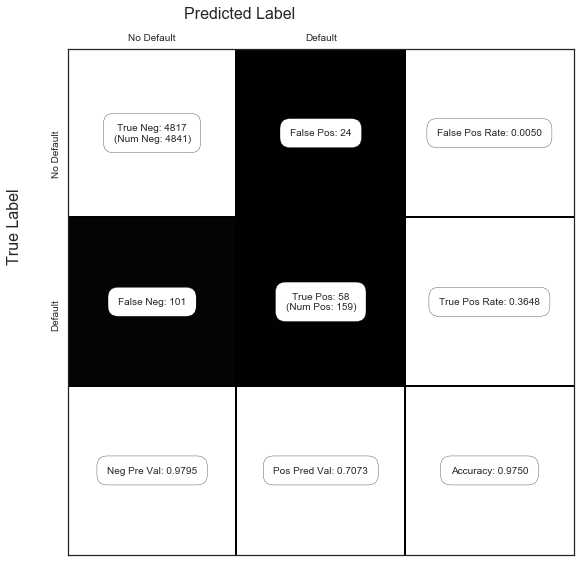

In [11]:
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.4f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.4f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.4f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.4f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.4f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()
C = confusion_matrix(y_test, y_pred)
show_confusion_matrix(C, ['No Default', 'Default'])

question 5 (c)
Anwer: 
First we keep a vector of the confusion matrices, and compute the different errors for each validation set.
The values below indicate that some quantities vary more than others when we change the validation set. In particular, the positive predicted value (PPV) varies from around 0.71 to around 0.81. The PPV is the ratio of the true positives over the sum of the true positives and false positives. Since both these quantities vary significantly in this case, the variance of the PPV is expected. The accuracy on the other handle is much more robust across different validation sets, for the opposite reason. The quantities involved in its computation do not vary as much. The denominator is a constant, and the numerator, TP + TN, is somewhat stable, since TP and TN would on average vary in opposite directions.



In [12]:
C = [C]
for i in range(1,4):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
    mod = lr.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
    C.append(confusion_matrix(y_test, y_pred))
tpr, fpr, ppv, npv, acc = ([] for i in range(5))

for c in C:
    tn = c[0,0] 
    fp = c[0,1]
    fn = c[1,0]
    tp = c[1,1]
    tpr.append((tp / (tp+fn+0.)))
    fpr.append((fp / (fp+tn+0.)))
    ppv.append((tp/(tp+fp+0.)))
    npv.append((1-fn/(fn+tn+0.)))
    acc.append(((tp+tn+0.)/(tn+fp+fn+tp)))
def line(l):
    return " ".join( '{:06.4f}'.format(a) for a in l) + ', Average: ' +'{:06.4f}'.format(sum(l)/ len(l))
    
print('TPR: ')
print(line(tpr))
print('FPR: ')
print(line(fpr))
print('PPV: ')
print(line(ppv))
print('NPV: ')
print(line(npv))
print('ACC: ')
print(line(acc))

TPR: 
0.3648 0.3452 0.3030 0.3293, Average: 0.3356
FPR: 
0.0050 0.0029 0.0041 0.0029, Average: 0.0037
PPV: 
0.7073 0.8056 0.7143 0.7941, Average: 0.7553
NPV: 
0.9795 0.9777 0.9767 0.9777, Average: 0.9779
ACC: 
0.9750 0.9752 0.9730 0.9752, Average: 0.9746


question 5 (d)
Answer: By comparing to the values below without the student dummy variable, adding the student variable seems to be not helping in any of the metrics because they are worse or very similar.

In [13]:
df['student_yes'] = (df['student'] == 'Yes').astype('int')
df.head()

,default,student,balance,income,default_yes,student_yes
1,No,No,729.526495,44361.625074,0,0
2,No,Yes,817.180407,12106.134700,0,1
3,No,No,1073.549164,31767.138947,0,0
4,No,No,529.250605,35704.493935,0,0
5,No,No,785.655883,38463.495879,0,0


In [14]:
X = df[['income','balance','student_yes']]
y = df['default_yes']

f = 'default_yes ~ income + balance + student_yes'

X_train, X_test, y_train, y_test = train_test_split(X, y)
train = X_train.join(y_train)


res = smf.logit(formula=f, data=train).fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.078115
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            default_yes   No. Observations:                 7500
Model:                          Logit   Df Residuals:                     7496
Method:                           MLE   Df Model:                            3
Date:                Tue, 06 Mar 2018   Pseudo R-squ.:                  0.4571
Time:                        08:45:36   Log-Likelihood:                -585.86
converged:                       True   LL-Null:                       -1079.2
                                        LLR p-value:                1.403e-213
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -10.8662      0.568    -19.114      0.000     -11.980      -9.752
income       2.768e-06   9.34e-06      0.296      0.767   -1.55e-05    2.11e-05
balance         0.0057      0.000     21.225      0.000       0.005       0.006
student_yes    -0.6343      0.270     -2.345      0.019      -1.164      -0.104
===============================================================================

Possibly complete quasi-separation: A fraction 0.15 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

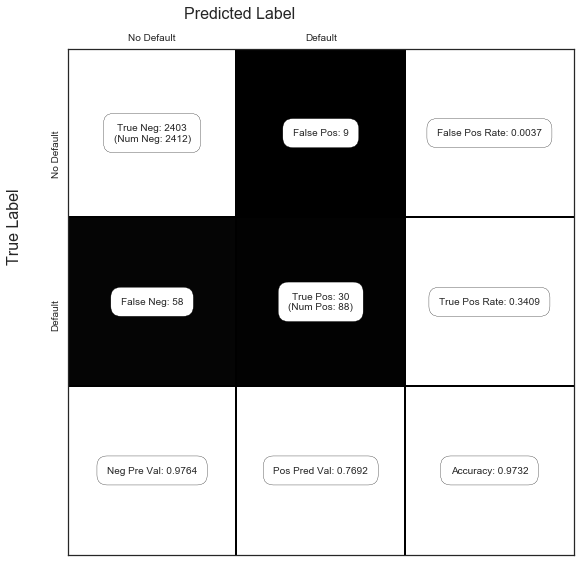

In [15]:
y_pred = (res.predict(X_test) > .5) * 1
C = confusion_matrix(y_test, y_pred)
show_confusion_matrix(C, ['No Default', 'Default'])